In [1]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
import pandas as pd
import sklearn.model_selection
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
def stringToDateTime(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return dt.datetime.strptime(datetime, '%Y-%m-%d %H:%M:%S')

In [3]:
def datetimeToFloat(columns):
    d=columns[0]
    return d.timestamp()

In [4]:
def extractMonth(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return datetime.month

In [5]:
def extractdayOfWeek(columns):
    date=columns[0]
    if pd.isnull(date):
        return date
    else:
        return date.weekday()

In [6]:
def extractday(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return datetime.day

In [7]:
def datetimeToFloat(columns):
    d=columns[0]
    return d.timestamp()

In [8]:
def formatDate(columns):
    datetime=columns[0]
    if pd.isnull(datetime):
        return datetime
    else:
        return str(datetime.day)+'/'+str(datetime.month)+'/'+str(datetime.year)

In [9]:
#Read the data
data=pd.read_csv('1.csv', delimiter='\t')

In [10]:
#Check the number of data and its datatype
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 2 columns):
time       517 non-null object
Visitor    517 non-null int64
dtypes: int64(1), object(1)
memory usage: 8.2+ KB


In [11]:
#Check the number of null values
data.isnull().sum()

time       0
Visitor    0
dtype: int64

In [12]:
#Convert date string to datetime object
data['time']=data[['time']].apply(stringToDateTime,axis=1)

In [13]:
#Extract day from datetime
data['day']=data[['time']].apply(extractday,axis=1)

In [14]:
#Extract month
data['month']=data[['time']].apply(extractMonth,axis=1)

In [15]:
#Extract day of the week
data['dayOfWeek']=data[['time']].apply(extractdayOfWeek,axis=1)

In [16]:
#Format the datetime for graph
data['formattedDate']=data[['time']].apply(formatDate,axis=1)

In [17]:
#Convert the datetime to time from epoch time
data['time']=data[['time']].apply(datetimeToFloat,axis=1)

In [18]:
#Create dummy variables for categorical day of the week
dayOfWeekDumyList = pd.get_dummies(data['dayOfWeek'], prefix='dayOfWeek')
data=data.join(dayOfWeekDumyList)
data=data.drop('dayOfWeek',axis=1)

In [19]:
#Create dummy variables for categorical month
monthDumyList = pd.get_dummies(data['month'], prefix='month')
data=data.join(monthDumyList)
data=data.drop('month',axis=1)

In [20]:
#Create dummy variables for categorical day
dayDumyList = pd.get_dummies(data['day'], prefix='day')
data=data.join(dayDumyList)
data=data.drop('day',axis=1)

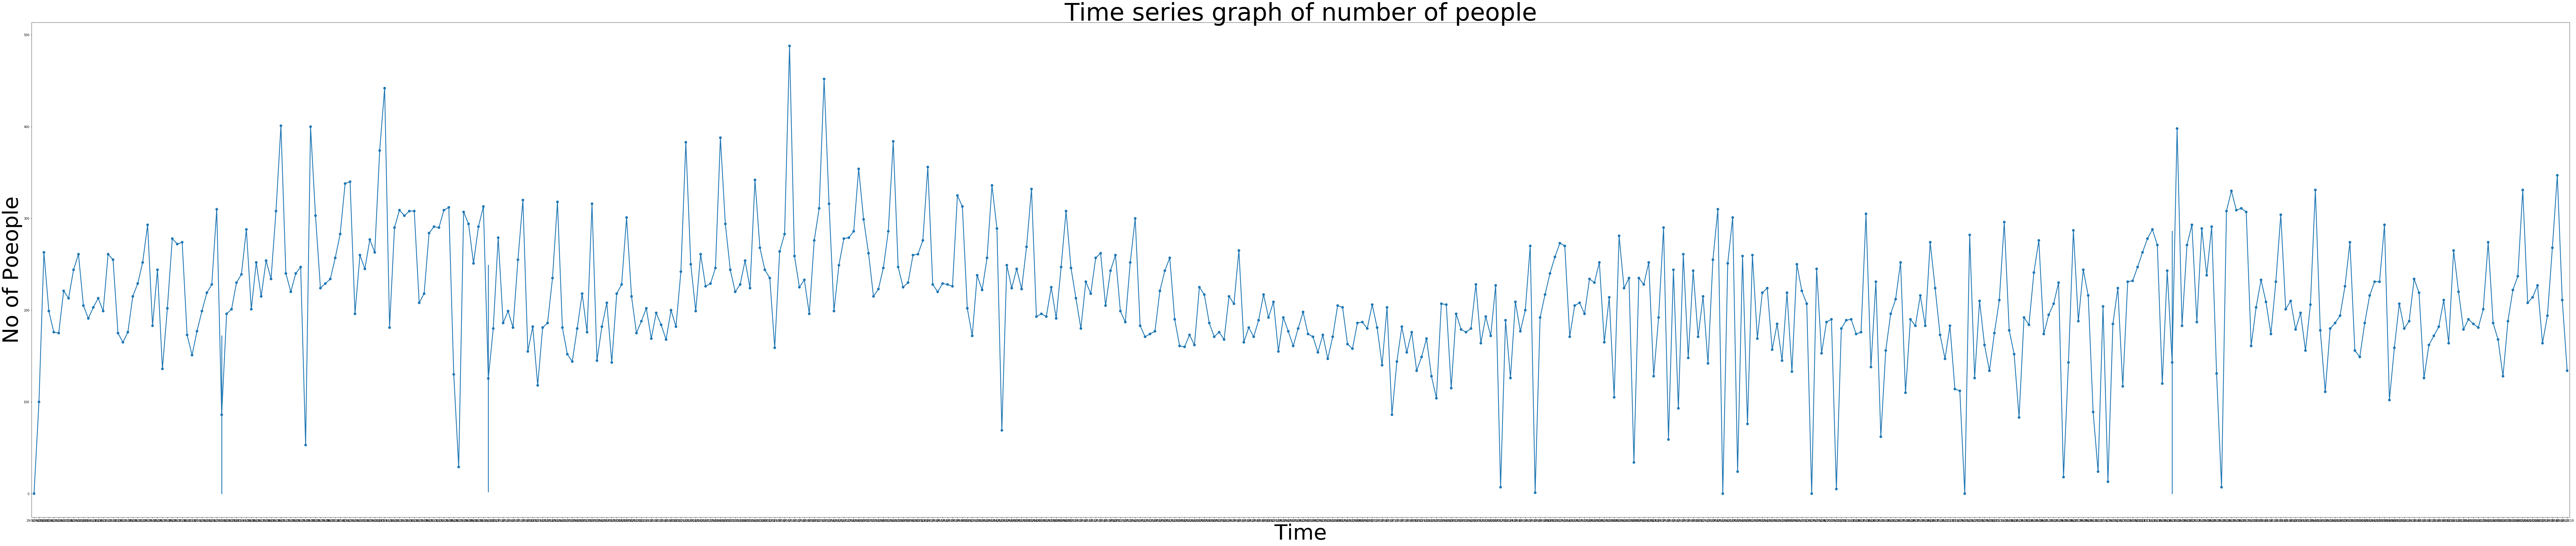

In [21]:
#Plot the graph No of people against Time
mpl.rcParams['figure.figsize']=150,30
fig=sns.pointplot(x='formattedDate',y='Visitor',data=data)
fig.set_xlabel('Time',fontsize=70)
fig.set_ylabel('No of Poeople',fontsize=70)
fig.axes.set_title('Time series graph of number of people',fontsize=80)
plt.show()

In [22]:
#Drop time and formatted date from the data
data=data.drop('time',axis=1)
data=data.drop('formattedDate',axis=1)

In [23]:
'''X_train, X_test = train_test_split(data, test_size=0.2)
X_train=X_train.values
X_test=X_test.values
X_train.shape'''

'X_train, X_test = train_test_split(data, test_size=0.2)\nX_train=X_train.values\nX_test=X_test.values\nX_train.shape'

In [24]:
#Normalise data to 0 to 1 range
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [25]:
#Split training and testing data
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
X_train, X_test = pd.DataFrame(data[0:train_size,:]), pd.DataFrame(data[train_size:len(data),:])
X_train=X_train.values
X_test=X_test.values
X_train.shape

(413, 51)

In [26]:
X_train.shape

(413, 51)

In [27]:
#Define the dimension,batch size and epochs of neural network
original_dim=X_train.shape[-1]
first_dim=int((3*original_dim)/4)
second_dim=int((3*first_dim)/4)
third_dim=int((3*second_dim)/4)

batch_size = 100
latent_dim=2
epochs = 100
epsilon_std=1.0

In [28]:
#Encoder layer definition
input_layer = Input(shape=(original_dim, ))
encoder = Dense(first_dim, activation="relu")(input_layer)
encoder = Dense(second_dim, activation="relu")(encoder)
encoder = Dense(third_dim, activation="relu")(encoder)
encoder = Dense(latent_dim, activation="relu")(encoder)

In [29]:
#Decoder layer definition
decoder = Dense(third_dim, activation="relu")(encoder)
decoder = Dense(second_dim, activation="relu")(decoder)
decoder = Dense(first_dim, activation="relu")(decoder)
decoder = Dense(original_dim, activation="sigmoid")(decoder)

In [30]:
#Create the auto encoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [31]:
#Display the summary of auto encoder
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 51)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                1976      
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1092      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                609       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 44        
_________________________________________________________________
dense_5 (Dense)              (None, 21)                63        
_________________________________________________________________
dense_6 (Dense)              (None, 28)                616       
__________

In [32]:
#Encoder model to plot and check the distribution in latent space
encoderModel = Model(input_layer, encoder)

In [33]:
#Compile the created auto encoder model
autoencoder.compile(optimizer='rmsprop', 
                    loss='mean_squared_error')

In [34]:
#Convert all the data to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [35]:
#Fit or Run the model
autoencoder.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/100
413/413 [==============================] - 0s 298us/step - loss: 0.2425
Epoch 2/100
413/413 [==============================] - 0s 38us/step - loss: 0.2256
Epoch 3/100
413/413 [==============================] - 0s 33us/step - loss: 0.1914
Epoch 4/100
413/413 [==============================] - 0s 40us/step - loss: 0.1476
Epoch 5/100
413/413 [==============================] - 0s 43us/step - loss: 0.1110
Epoch 6/100
413/413 [==============================] - 0s 33us/step - loss: 0.0864
Epoch 7/100
413/413 [==============================] - 0s 42us/step - loss: 0.0715
Epoch 8/100
413/413 [==============================] - 0s 33us/step - loss: 0.0631
Epoch 9/100
413/413 [==============================] - 0s 32us/step - loss: 0.0589
Epoch 10/100
413/413 [==============================] - 0s 46us/step - loss: 0.0570
Epoch 11/100
413/413 [==============================] - 0s 36us/step - loss: 0.0561
Epoch 12/100
413/413 [==============================] - 0s 46us/step - loss: 0.0556


413/413 [==============================] - 0s 41us/step - loss: 0.0460
Epoch 99/100
413/413 [==============================] - 0s 31us/step - loss: 0.0459
Epoch 100/100
413/413 [==============================] - 0s 31us/step - loss: 0.0456


In [36]:
#Predict values based on test dataset
preds=autoencoder.predict(X_test, batch_size=batch_size)

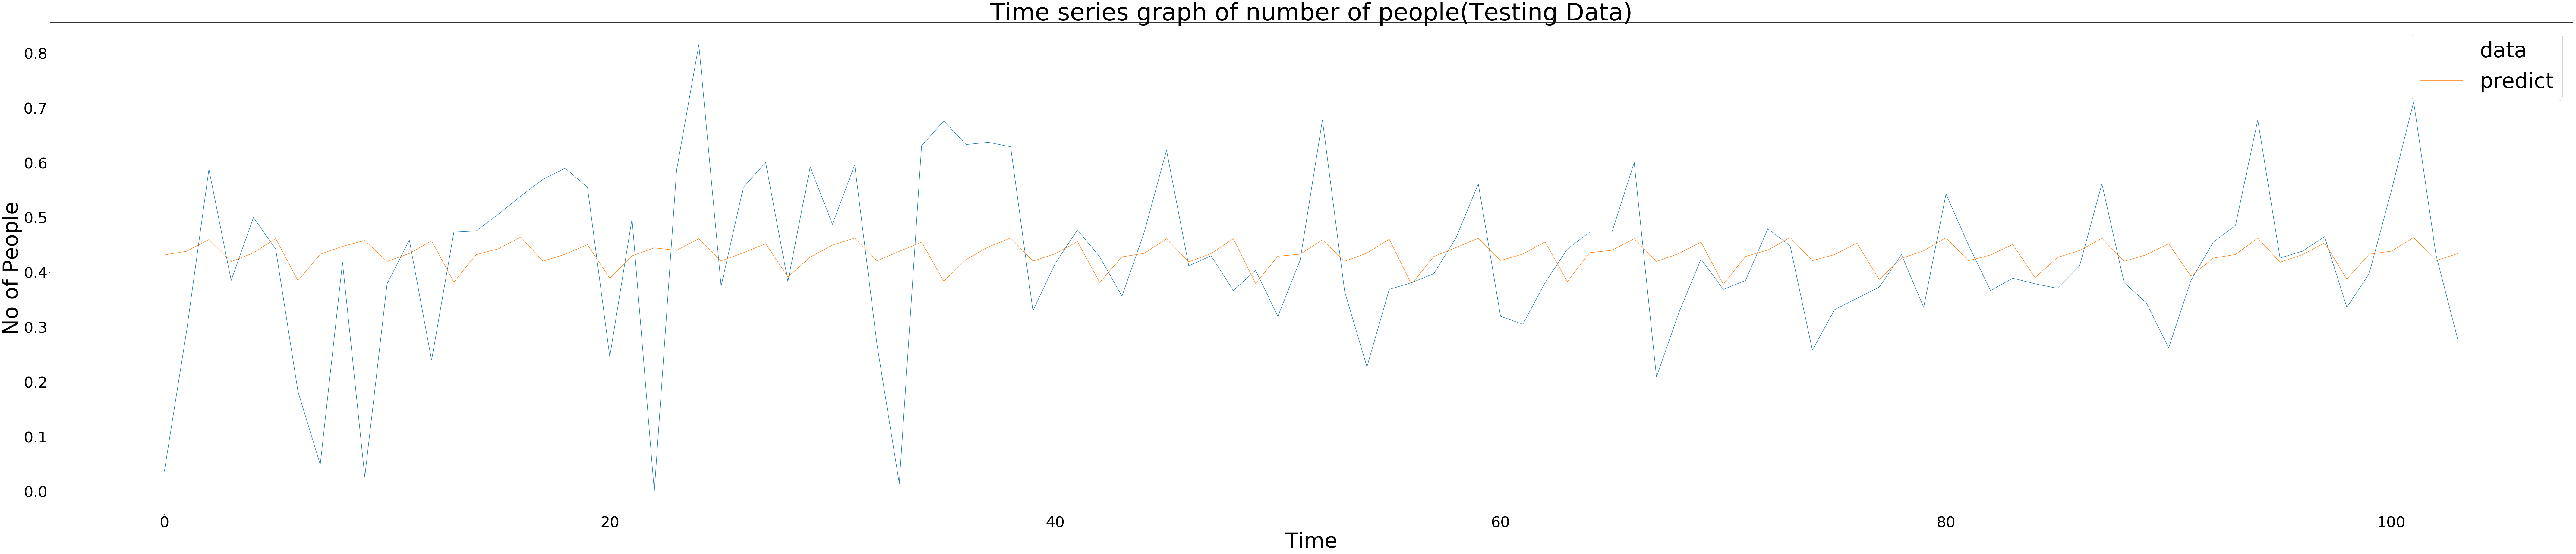

In [37]:
#Plot test dataset and predicted dataset based on test dataset
plt.plot(X_test[:,0], label='data')
plt.plot(preds[:,0], label='predict')
plt.xlabel('Time',fontsize=70)
plt.ylabel('No of People',fontsize=70)
plt.tick_params(labelsize=50)
plt.title('Time series graph of number of people(Testing Data)',fontsize=80)
plt.legend(fontsize=70)
plt.show()

In [38]:
#Predict values based on train dataset
preds=autoencoder.predict(X_train, batch_size=batch_size)

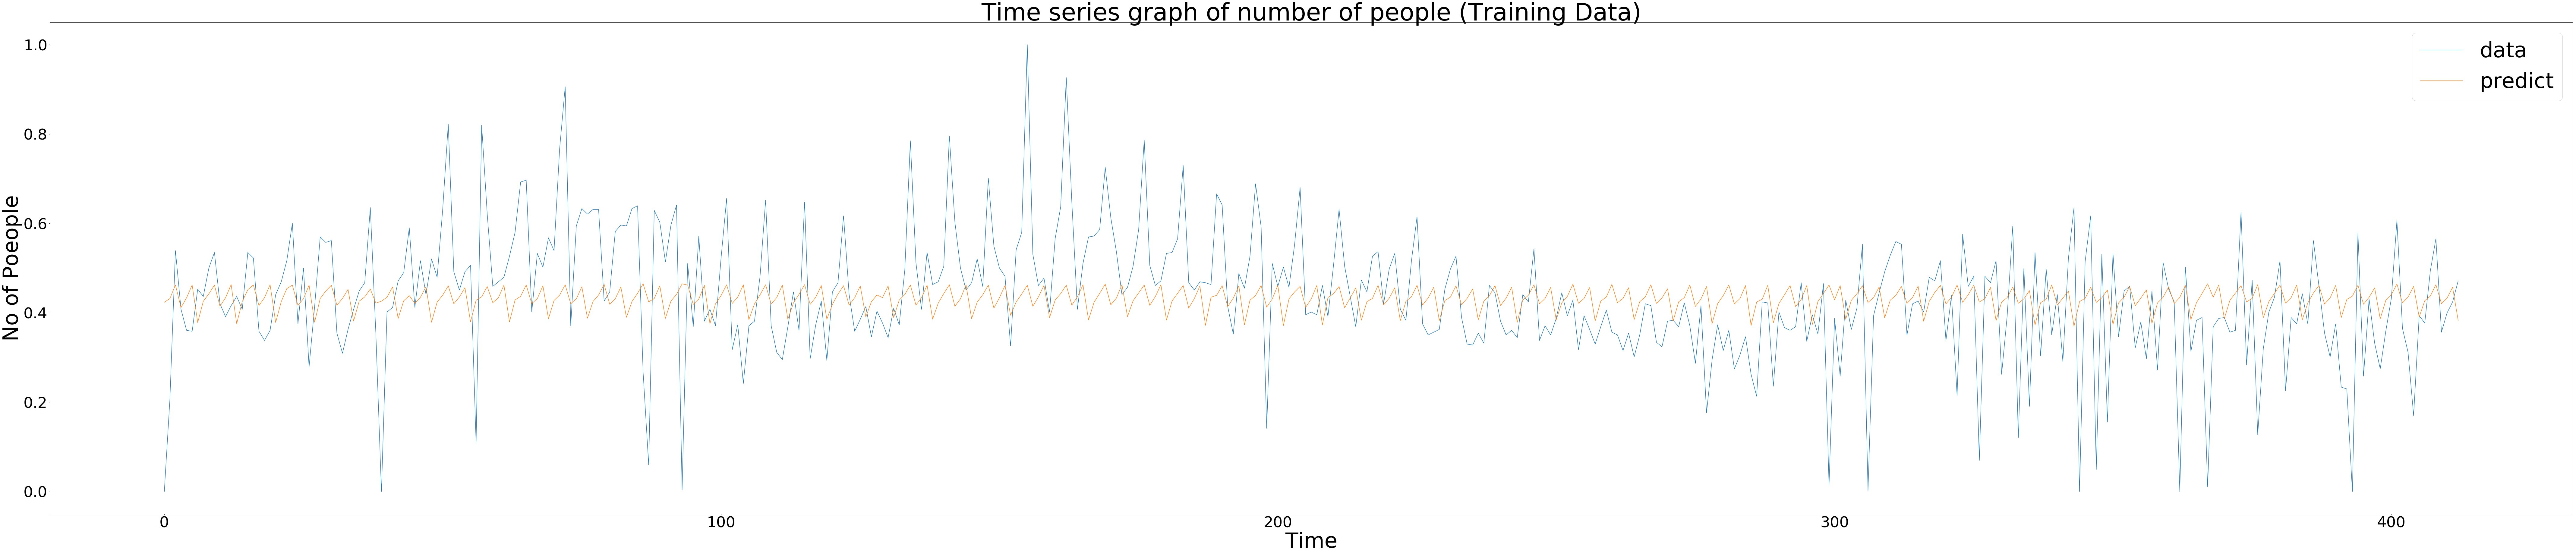

In [39]:
#Plot test dataset and predicted dataset based on train dataset
plt.plot(X_train[:,0], label='data')
plt.plot(preds[:,0], label='predict')
plt.xlabel('Time',fontsize=70)
plt.ylabel('No of Poeople',fontsize=70)
plt.tick_params(labelsize=50)
plt.title('Time series graph of number of people (Training Data)',fontsize=80)
plt.legend(fontsize=70)
plt.show()